### Controller Demo

In [1]:
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import pandas as pd
import sys
import scipy.stats
import pylab as plt
from IPython import display
import pylab as plt

In [4]:
sys.path.append('../codes')

In [5]:
from VMSfunctions.Chemicals import *
from VMSfunctions.Chromatograms import *
from VMSfunctions.MassSpec import *
from VMSfunctions.Controller import *
from VMSfunctions.Common import *
from VMSfunctions.DataGenerator import *

We want a notebook that does the following:
1. create a list of chemical
2. create a new mass spec object, takes chemicals
3. create a new controller, takes mass spec
4. write mzml files

Load densities trained on 4 beer data (see [loader_kde](loader_kde.ipynb)).

In [7]:
ps = load_obj('../models/peak_sampler_4_beers.p')

Load chromatogram data exported from R

In [8]:
xcms_output = '../models/beer_ms1_peaks.csv.gz'
chromatograms = ChromatogramCreator(xcms_output)

0


../codes\VMSfunctions\Common.py:50: RuntimeWarning:

divide by zero encountered in double_scalars



5000
10000
15000
20000
25000
30000
35000
40000
45000


### Generate some chemicals

In [9]:
chemicals = ChemicalCreator(ps, chromatograms)

In [10]:
min_ms1_intensity = 2E5
min_rt = 3*60
max_rt = 21*60
sampled_chemicals = chemicals.sample(min_rt, max_rt, min_ms1_intensity, 100, 2, 'Unknown', 'Empirical', None, False)

UnknownChemical mz=104.6089 rt=425.68 max_intensity=1.00


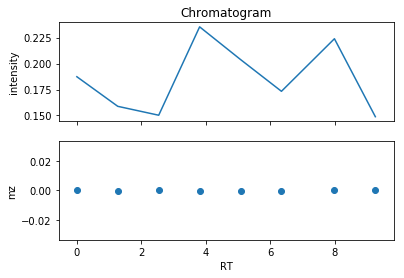

UnknownChemical mz=143.5884 rt=480.79 max_intensity=1.00


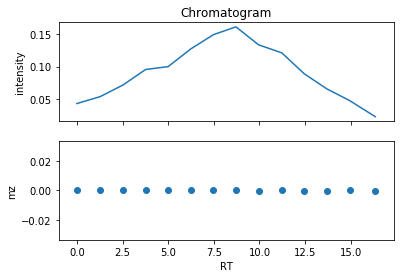

UnknownChemical mz=412.6526 rt=907.02 max_intensity=1.00


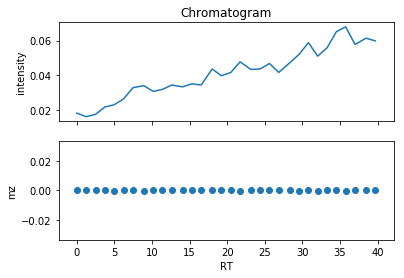

UnknownChemical mz=232.2203 rt=905.91 max_intensity=1.00


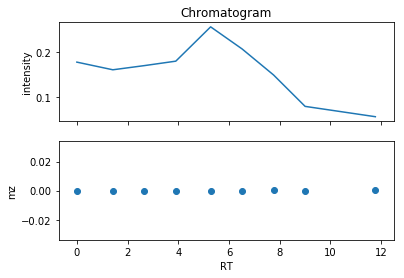

UnknownChemical mz=224.9625 rt=812.94 max_intensity=1.00


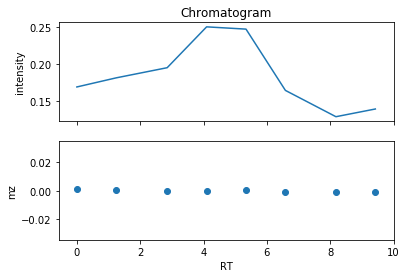

UnknownChemical mz=228.2880 rt=252.14 max_intensity=1.00


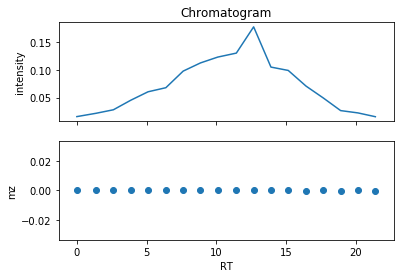

UnknownChemical mz=350.5850 rt=265.63 max_intensity=1.00


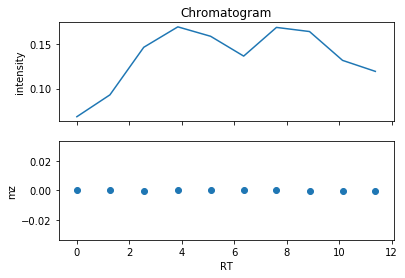

UnknownChemical mz=199.4921 rt=1043.53 max_intensity=1.00


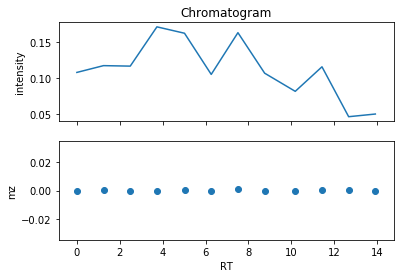

UnknownChemical mz=71.7027 rt=1022.54 max_intensity=1.00


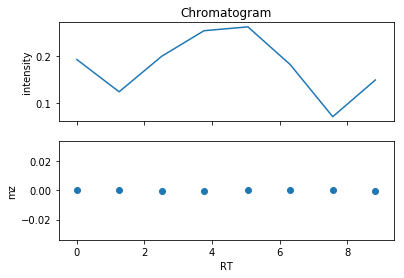

UnknownChemical mz=207.7223 rt=396.30 max_intensity=1.00


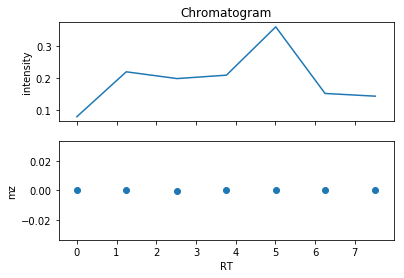

In [11]:
def plot_chromatogram(chrom):
    f, axarr = plt.subplots(2, sharex=True)
    axarr[0].plot(chrom.rts, chrom.intensities)
    axarr[0].set_title('Chromatogram')
    axarr[0].set_ylabel('intensity')
    axarr[1].scatter(chrom.rts, chrom.mzs)
    axarr[1].set_ylabel('mz')
    axarr[1].set_xlabel('RT')    
    plt.show()

for chem in sampled_chemicals[0:10]:
    print(chem)
    plot_chromatogram(chem.chromatogram)

### Set up a simple MS1 controller

Acquisition open


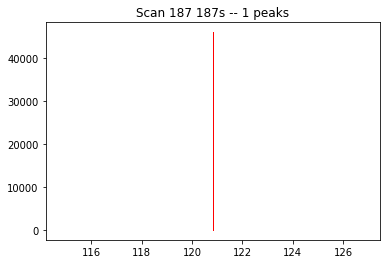

120.82898748671003 46000.60956904105


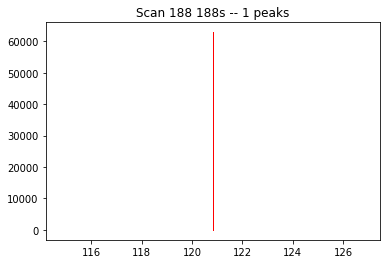

120.82950077930869 62892.70029522713


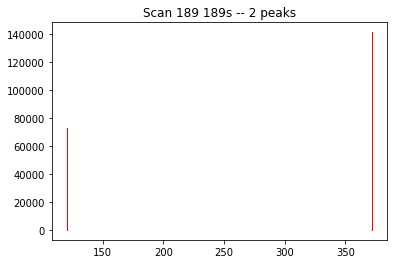

120.8295625637278 72943.09577277709
371.43914720631926 141314.1689990066


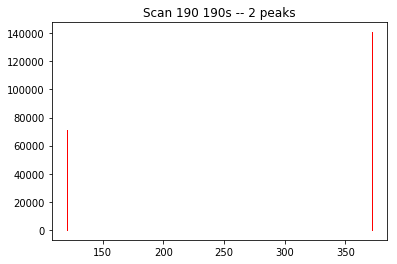

120.82958013047848 70964.24788990979
371.4391713010327 140722.04650126328


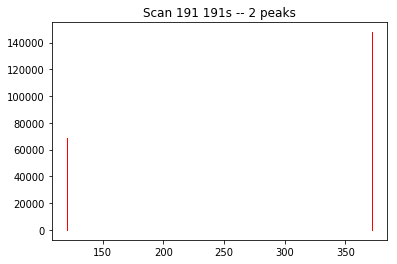

120.82959824047266 68398.9067361699
371.4391624038441 147682.15847271148


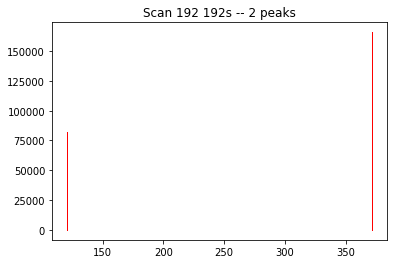

120.82955434084188 82099.86220538727
371.4391002096255 165794.6366873164


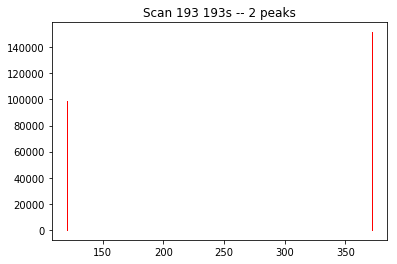

120.82959643405293 99190.64188589554
371.43916037835186 151510.80189418237


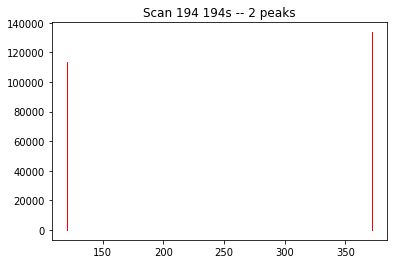

120.82955553810322 113670.8057782614
371.43913287085826 133664.13474968984


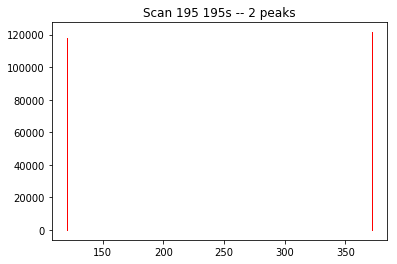

120.82950747516838 117808.35153347312
371.4391371383132 121450.51803650684


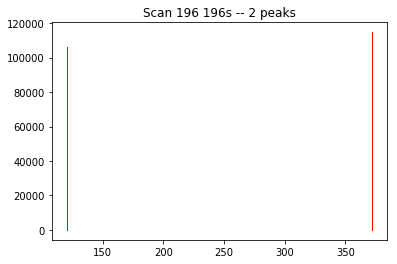

120.82955231427721 106238.32315150833
371.4391747620424 114688.97379370256


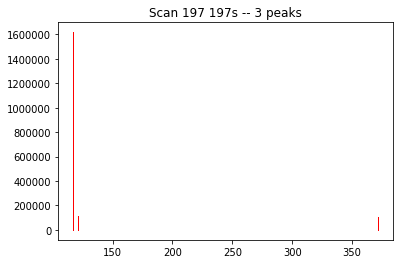

117.27505766359579 1617613.5310935087
120.82955231427721 111781.0693905804
371.43918498226276 108008.03890398094


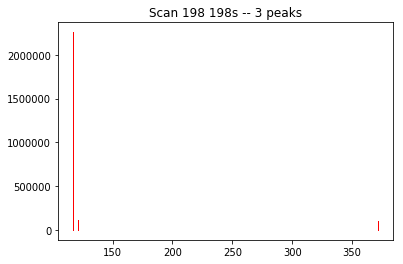

117.27508658603797 2257155.483083169
120.82955231427721 107641.54596011453
371.43913977362985 96632.30178202102


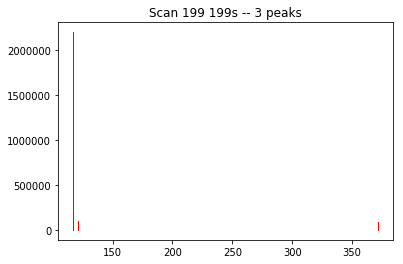

117.27504990625671 2198401.0644688946
120.82945621513525 102985.20427549271
371.4391046089214 85164.61100820974


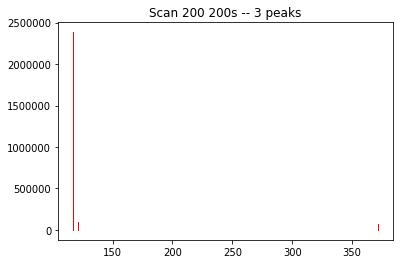

117.27504651403741 2383914.007897385
120.82935893115753 98765.64882115838
371.4391017161301 75159.94776831285


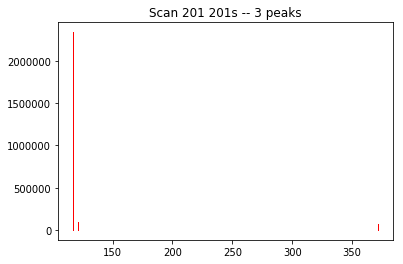

117.27506160757184 2339784.640976762
120.82957570953484 89882.71071543102
371.43912589804614 66258.88125127481


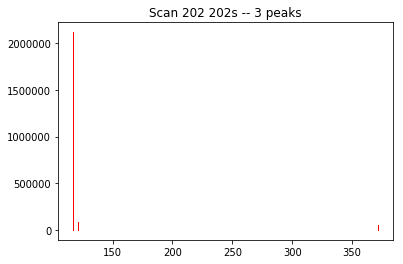

117.27508734465019 2117076.2718056804
120.82937234514833 87556.71583136314
371.4391380860892 56185.62056304358


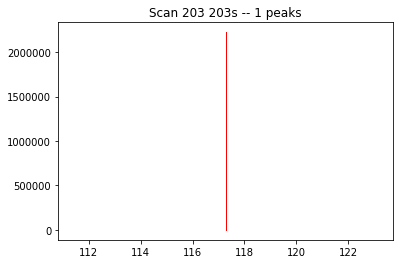

117.27512414237286 2222496.611904974


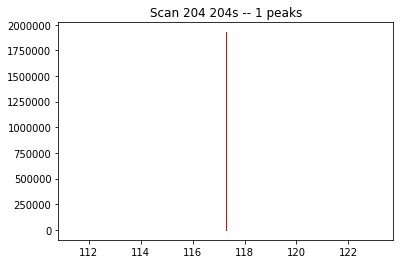

117.27510213587068 1926293.2137397293


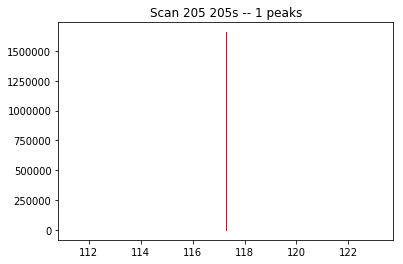

117.27512145952286 1656811.314360181
Acquisition closing


In [12]:
max_rt = 225
mass_spec = IndependentMassSpectrometer(POSITIVE, sampled_chemicals)
controller = SimpleMs1Controller(mass_spec)
controller.run(max_rt)

### Set up a Top-N controller

Acquisition open
Scan 187 -- num_peaks=1 rt=187.00 ms_level=1
Isolated precursor ion 120.82898748671003 window [[(120.8283833417726, 120.82959163164747)]]



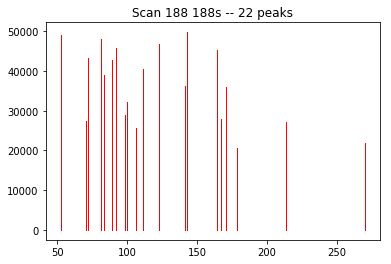

52.488259933464356 48936.23845945004
70.62511321812866 27332.965145406495
71.99943955215758 43147.73644587768
72.24094211186879 30460.998497464137
80.96924689612332 48138.40146108256
83.38024280466136 38947.847254866814
88.88040478924003 42667.12480918796
91.7333883086498 45897.028389939696
98.09656208668737 29018.672540446998
100.12011645952356 32181.512326352742
106.53750124265812 25622.924347772194
111.54709133146567 40577.0990693433
122.43879882270974 46707.481777536785
122.89816822729573 34031.45378799359
141.09973757163047 36127.62818948241
142.46152193526024 49741.133495077534
164.1971286197244 45235.91733005108
166.76623696795914 27839.259437542754
170.29988064853407 35841.1492379681
178.33462860311943 20694.8468657795
213.63323093028902 27250.075461370616
270.0272735284857 21887.13986550012

Scan 189 -- num_peaks=2 rt=189.00 ms_level=1
Isolated precursor ion 371.43914720631926 window [[(371.43729001058324, 371.4410044020553)]]
Excluded precursor ion 120.8295625637278 189 Exclu

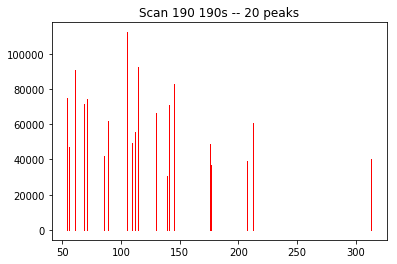

54.08827797433721 74971.51873039351
55.931990660211675 46924.02636672822
61.128450462798554 90739.22598412767
68.13921847203923 71713.87945553118
70.67685101019593 74072.04004294888
85.35328926709144 41766.447541439804
88.91557388661515 61644.44305719121
105.52210988891717 112238.59985523668
109.16113963750577 49498.001010183034
111.81932757364542 55458.765776197455
114.46786346536122 92751.38865245806
129.83985864047017 66506.71780062802
139.19415442850402 30391.397687643293
140.73058162826518 70768.55498921912
145.07329310027706 82766.87666595746
175.59084567096158 48905.41949519882
176.57578609575478 37015.38207001719
207.69572176023743 39307.86451802509
212.4644423333954 60627.21400155541
313.50806220674014 40114.00163841103

Scan 191 -- num_peaks=2 rt=191.00 ms_level=1
Excluded precursor ion 371.4391624038441 191 ExclusionItem(from_mz=371.43729001058324, to_mz=371.4410044020553, from_rt=159, to_rt=219)
Isolated precursor ion 120.82959824047266 window [[(120.82899409248145, 120.830

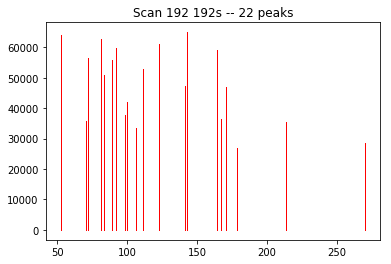

52.488259933464356 63881.15656525115
70.62511321812866 35680.3358985816
71.99943955215758 56324.87077279706
72.24094211186879 39763.657269301584
80.96924689612332 62839.66355698703
83.38024280466136 50842.353370279765
88.88040478924003 55697.48239606479
91.7333883086498 59913.78472799898
98.09656208668737 37880.85112851728
100.12011645952356 42009.6086692439
106.53750124265812 33448.055948884146
111.54709133146567 52969.171726599365
122.43879882270974 60971.74711684969
122.89816822729573 44424.5143478966
141.09973757163047 47160.85145399717
142.46152193526024 64931.86310519331
164.1971286197244 59050.773175552866
166.76623696795914 36341.250303983834
170.29988064853407 46786.883054903745
178.33462860311943 27014.964663093444
213.63323093028902 35572.13205925448
270.0272735284857 28571.3788498912

Scan 193 -- num_peaks=2 rt=193.00 ms_level=1
Excluded precursor ion 371.43916037835186 193 ExclusionItem(from_mz=371.43729001058324, to_mz=371.4410044020553, from_rt=159, to_rt=219)
Excluded p

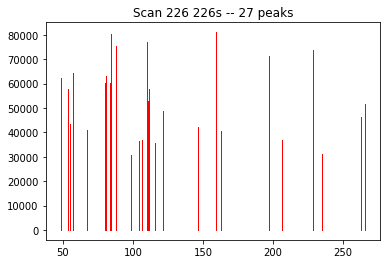

48.48313317448085 62264.54863055606
53.76834598383803 57753.22052716237
55.20983221348277 43557.26640567537
57.467335138217166 64270.97676759111
67.50841313341348 41120.11817149572
79.95129337000823 60114.93060949081
80.55625875600867 63072.63776705552
83.70067626527992 60204.85198668847
84.10671409828926 80186.70495142722
88.18689276868182 75264.84354791138
98.4681871670529 30683.309536786604
104.64894342359878 36268.87330802491
106.68479512490225 36999.339748335835
109.93712624705834 77177.18823841501
111.00775184263645 52844.42061393328
111.62490893087099 57715.542561523915
115.73552393192487 35617.77463315008
121.33824106709311 48966.5305555781
146.24118435807267 42314.11648040705
159.17586403159336 81060.55491723704
162.88790361576102 40758.64478699835
196.99291136404645 71137.59202447758
206.60468891922545 37048.4299467718
228.52298222672573 73602.55783080384
234.76997296799337 31074.78964454221
262.8730847187635 46406.06130434924
265.85188573336035 51703.86479215847

Scan 227 --

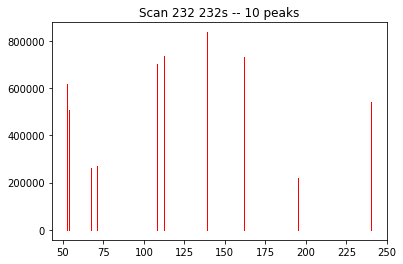

52.5928205521778 616313.3113049641
53.92171216888851 508506.8360974412
67.12045216099189 261495.63306086036
71.12575626961024 270369.59507853625
107.84601403324349 699860.419309391
112.43409686666104 733854.7237873332
138.82251764084393 836140.4900467731
161.84138547432372 730764.2013177174
195.05875472292865 218230.76487977267
240.44868256741339 539055.0601917838

Scan 233 -- num_peaks=2 rt=233.00 ms_level=1
Excluded precursor ion 286.0614255837595 233 ExclusionItem(from_mz=286.05988339376745, to_mz=286.0627440069045, from_rt=201, to_rt=261)
Excluded precursor ion 209.55205298977526 233 ExclusionItem(from_mz=209.550913568486, to_mz=209.55300908809932, from_rt=195, to_rt=255)

Scan 234 -- num_peaks=2 rt=234.00 ms_level=1
Excluded precursor ion 286.06146356054995 234 ExclusionItem(from_mz=286.05988339376745, to_mz=286.0627440069045, from_rt=201, to_rt=261)
Excluded precursor ion 209.55208670127277 234 ExclusionItem(from_mz=209.550913568486, to_mz=209.55300908809932, from_rt=195, to_rt=2

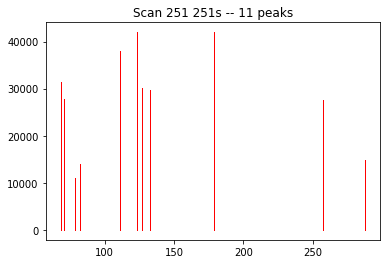

68.45737825204563 31491.129213445874
71.06857129064619 27848.704104872537
78.67980815398866 11048.786821743599
81.99847444275937 13895.294966955988
110.8623817722031 37902.25900439649
123.45551039282284 41976.8588484128
127.04989244846853 30219.123844926708
132.86664292185233 29652.723063561538
178.957568664132 41940.55653888312
257.1402226067734 27687.836381534482
287.8188815150663 14859.02613925968

Scan 252 -- num_peaks=2 rt=252.00 ms_level=1
Isolated precursor ion 101.07267844766709 window [[(101.07217308427485, 101.07318381105932)]]
Excluded precursor ion 109.80274716931017 252 ExclusionItem(from_mz=109.80220459044709, to_mz=109.80330261798314, from_rt=220, to_rt=280)



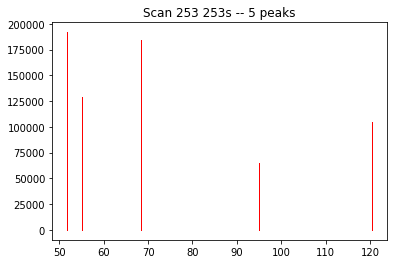

51.79973309317126 191807.59712370063
55.17848627505117 129380.09807493111
68.34000130236663 183811.3187291722
95.03160509761892 65322.04445457864
120.36663123314597 104470.44536844511

Scan 254 -- num_peaks=3 rt=254.00 ms_level=1
Isolated precursor ion 101.07210300553555 window [[(101.07159764502052, 101.07260836605059)]]
Excluded precursor ion 109.80272386993771 254 ExclusionItem(from_mz=109.80220459044709, to_mz=109.80330261798314, from_rt=220, to_rt=280)
Isolated precursor ion 227.28080879290113 window [[(227.27967238885716, 227.2819451969451)]]



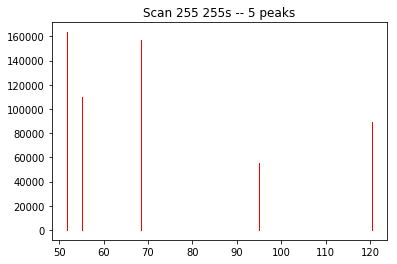

51.79973309317126 163477.4534826328
55.17848627505117 110270.54862160898
68.34000130236663 156662.23214167278
95.03160509761892 55673.92347252518
120.36663123314597 89040.0725994998



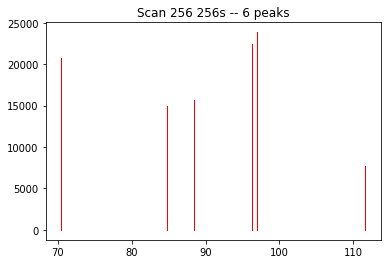

70.41708032619266 20795.492660078322
84.81548132554732 14990.853573530163
88.38757460195839 15658.968263625453
96.3204761915365 22407.440465979787
96.91648901632658 23851.463231272737
111.63747003018064 7664.383153854785

Scan 257 -- num_peaks=3 rt=257.00 ms_level=1
Excluded precursor ion 101.0718487843154 257 ExclusionItem(from_mz=101.07159764502052, to_mz=101.07260836605059, from_rt=224, to_rt=284)
Excluded precursor ion 109.80273272231597 257 ExclusionItem(from_mz=109.80220459044709, to_mz=109.80330261798314, from_rt=220, to_rt=280)
Excluded precursor ion 227.28073445201323 257 ExclusionItem(from_mz=227.27967238885716, to_mz=227.2819451969451, from_rt=224, to_rt=284)

Scan 258 -- num_peaks=3 rt=258.00 ms_level=1
Excluded precursor ion 101.07246799099492 258 ExclusionItem(from_mz=101.07217308427485, to_mz=101.07318381105932, from_rt=222, to_rt=282)
Isolated precursor ion 109.8021409237091 window [[(109.80159191300449, 109.80268993441372)]]
Excluded precursor ion 227.2806989118893 258

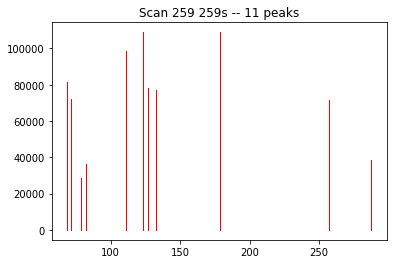

68.45737825204563 81736.51445803988
71.06857129064619 72282.45104445757
78.67980815398866 28677.57830080133
81.99847444275937 36065.80666787873
110.8623817722031 98376.86416727358
123.45551039282284 108952.65479084276
127.04989244846853 78434.9724749001
132.86664292185233 76964.85607033077
178.957568664132 108858.43066100539
257.1402226067734 71864.91228599225
287.8188815150663 38567.21036047896

Scan 260 -- num_peaks=2 rt=260.00 ms_level=1
Excluded precursor ion 101.07220204313063 260 ExclusionItem(from_mz=101.07217308427485, to_mz=101.07318381105932, from_rt=222, to_rt=282)
Excluded precursor ion 227.28078891446506 260 ExclusionItem(from_mz=227.27967238885716, to_mz=227.2819451969451, from_rt=224, to_rt=284)

Scan 261 -- num_peaks=2 rt=261.00 ms_level=1
Excluded precursor ion 101.0724076116297 261 ExclusionItem(from_mz=101.07217308427485, to_mz=101.07318381105932, from_rt=222, to_rt=282)
Excluded precursor ion 227.28081350558352 261 ExclusionItem(from_mz=227.27967238885716, to_mz=227

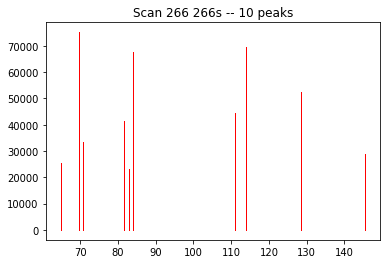

64.8609813223636 25530.66541387303
69.78802715831208 75140.83051340154
70.76527468507493 33582.279555308916
81.68917017834916 41462.872464161876
82.858023990998 23028.6771043105
83.96515558608563 67626.3393624375
111.07298199146683 44501.45852782502
113.82401588175449 69629.49899134519
128.50924591693737 52264.75737185452
145.48921998741517 28989.515667371885

Scan 267 -- num_peaks=5 rt=267.00 ms_level=1
Isolated precursor ion 126.52767161808401 window [[(126.52703897972592, 126.52830425644211)]]
Excluded precursor ion 101.07207478019963 267 ExclusionItem(from_mz=101.07159764502052, to_mz=101.07260836605059, from_rt=224, to_rt=284)
Excluded precursor ion 454.4695647791923 267 ExclusionItem(from_mz=454.4674037067169, to_mz=454.4719484034775, from_rt=235, to_rt=295)
Isolated precursor ion 349.57783573617667 window [[(349.57608784699795, 349.5795836253554)]]
Excluded precursor ion 227.2807220830648 267 ExclusionItem(from_mz=227.27967238885716, to_mz=227.2819451969451, from_rt=224, to_rt=2

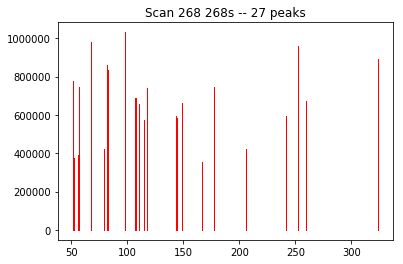

51.70308673631152 775211.9924039113
51.93953898888231 373138.7685071157
56.33293750398077 393451.442596222
56.92585400719558 747523.187390961
67.09671947174898 981847.0213793996
67.72331474543516 749421.549429872
79.28445816499276 423166.0383794455
81.90321412326696 861953.0161477113
82.63854273765374 835047.0024987576
97.46477484093298 1031321.0833437521
106.68798783572956 688493.559142667
107.7066072437263 686311.1362750133
110.28305576033169 658974.8406419094
114.66381086359489 402747.600981035
114.94273420090424 570904.8308161189
117.6717033954441 286304.5771199932
117.86791849371569 741157.9453137938
143.27555206210752 592243.7927386886
143.96867763053166 582051.1089086557
148.5569531490832 660474.2552634885
166.4994570017122 352702.81017332355
177.3014611444074 746306.1089474291
205.6707557717627 424135.13727926265
241.79855551758644 595788.6967717096
252.07872818776497 957420.1937276743
259.31256582001305 670410.68507116
323.3780384344515 890934.2442176419



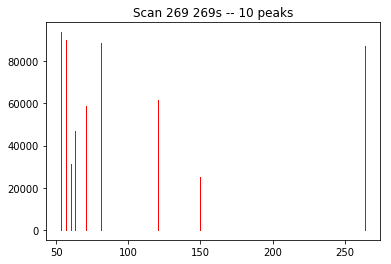

53.017674515467014 44654.21987416938
53.427306284481546 93725.61751785137
56.33253346109451 89991.6263818135
60.345970114587864 31254.644781373398
62.706151420714264 46723.930472985034
70.53050278780599 58635.13706450824
80.69682284552958 88692.76787646677
120.50033236752805 61509.12627860178
149.75196475018714 24881.951237217527
264.3136021311872 86981.23984231807

Scan 270 -- num_peaks=4 rt=270.00 ms_level=1
Excluded precursor ion 101.0729664385039 270 ExclusionItem(from_mz=101.07217308427485, to_mz=101.07318381105932, from_rt=222, to_rt=282)
Excluded precursor ion 349.577746562536 270 ExclusionItem(from_mz=349.57608784699795, to_mz=349.5795836253554, from_rt=237, to_rt=297)
Excluded precursor ion 454.46948754522714 270 ExclusionItem(from_mz=454.4674037067169, to_mz=454.4719484034775, from_rt=235, to_rt=295)
Excluded precursor ion 227.28065267412907 270 ExclusionItem(from_mz=227.27967238885716, to_mz=227.2819451969451, from_rt=224, to_rt=284)

Scan 271 -- num_peaks=4 rt=271.00 ms_lev

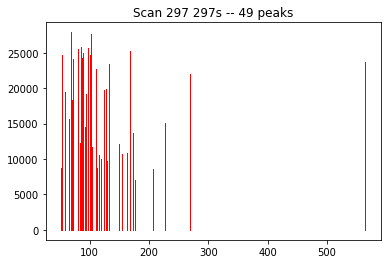

51.325463412453935 8731.281317265206
53.92357371863894 24697.63844502408
58.557930885863804 19497.128661178132
58.903919053688746 9712.406971338076
65.15529251523917 15609.705854091952
67.5842311587486 14566.458564088844
67.74935926888055 27897.406412602835
69.51820597622972 18327.695908725982
70.20759947778333 17551.581002402287
70.34562061145503 16545.67644124844
71.34082117168413 24073.8925307359
79.88247707742278 22244.32609533963
80.22859175724047 9073.690881641918
80.46321999972497 25579.736482284905
80.616667108154 15077.525325136136
83.149928531519 12314.863740906485
84.01653863761479 9865.83648354221
84.60698493352955 25753.66802010703
85.59169222549602 17675.756252715575
85.77093801984061 24902.854054387437
86.63607659915502 24241.372964467155
88.58655383908352 25036.541423080515
92.25737071623351 14587.40716791941
94.10229449831091 19232.037079771675
97.60634685834603 25688.256328317646
97.82805847545659 7930.37247494143
99.80868938203734 24621.92915311812
101.4797208359617 

In [13]:
max_rt = 300                    # the maximum retention time of scans to generate
N = 5                           # top-5 DDA fragmentation
mz_tol = 5                      # the mz isolation window around a selected precursor ion
rt_tol = 30                     # the rt window around a selected precursor ion to prevent it from fragmented multiple times
min_ms2_intensity = 5000        # the minimum ms2 peak intensity

mass_spec = IndependentMassSpectrometer(POSITIVE, sampled_chemicals)
controller = TopNController(mass_spec, N, mz_tol, rt_tol, min_ms2_intensity=min_ms2_intensity)
controller.run(max_rt)

In [14]:
controller.write_mzML('my_analysis', '../models/out.mzML')

c:\users\joewa\.virtualenvs\simulator-g4ninw5e\lib\site-packages\psims\utils.py:408: StateTransitionWarning:

Transition from 'controlled_vocabularies' to 'run' is not valid. Expected one of ['file_description']

../codes\VMSfunctions\Controller.py:187: UserWarning:

No Data Processing method found. mzML file may not be fully standard-compliant

c:\users\joewa\.virtualenvs\simulator-g4ninw5e\lib\site-packages\psims\mzml\writer.py:412: ReferentialIntegrityWarning:

A reference key for DataProcessing should not be "None"

c:\users\joewa\.virtualenvs\simulator-g4ninw5e\lib\site-packages\psims\document.py:92: ReferentialIntegrityWarning:

Overwriting existing value for 254 with 'SPECTRUM_254' in store Spectrum

c:\users\joewa\.virtualenvs\simulator-g4ninw5e\lib\site-packages\psims\document.py:92: ReferentialIntegrityWarning:

Overwriting existing value for 267 with 'SPECTRUM_267' in store Spectrum

